<a href="https://colab.research.google.com/github/danieldalton13/optimisation_top_Y1/blob/main/joints_residuals_optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geometry Check

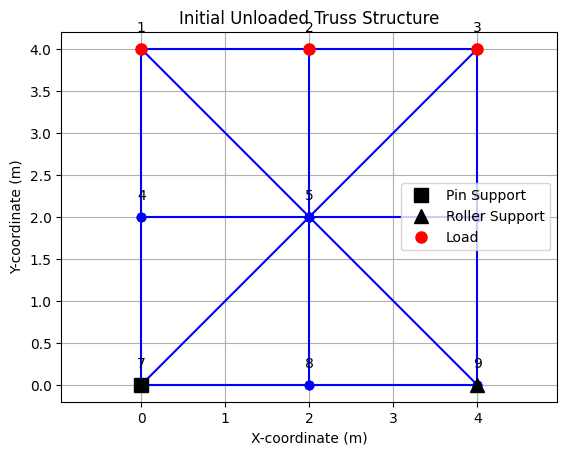

In [ ]:
import matplotlib.pyplot as plt

# Define node coordinates
nodes = {
    1: (0, 4),
    2: (2, 4),
    3: (4, 4),
    4: (0, 2),
    5: (2, 2),
    6: (4, 2),
    7: (0, 0),
    8: (2, 0),
    9: (4, 0)
}

# Define members as pairs of nodes
members = [
    (1, 2), (2, 3),
    (4, 5), (5, 6),
    (7, 8), (8, 9),
    (1, 4), (4, 7),
    (2, 5), (5, 8),
    (3, 6), (6, 9),
    (1, 5), (3, 5), (5, 7), (5, 9)
]

# Plot each member
for member in members:
    x_values = [nodes[member[0]][0], nodes[member[1]][0]]
    y_values = [nodes[member[0]][1], nodes[member[1]][1]]
    plt.plot(x_values, y_values, 'b-o')  # Blue lines with circle markers

# Highlight supports
plt.plot(nodes[7][0], nodes[7][1], 'ks', markersize=10, label='Pin Support')   # Square for pin
plt.plot(nodes[9][0], nodes[9][1], 'k^', markersize=10, label='Roller Support')  # Triangle for roller

# Highlight loaded nodes
plt.plot(nodes[1][0], nodes[1][1], 'ro', markersize=8, label='Load')  # Red circles for loads
plt.plot(nodes[2][0], nodes[2][1], 'ro', markersize=8)
plt.plot(nodes[3][0], nodes[3][1], 'ro', markersize=8)

# Annotate nodes
for node, (x, y) in nodes.items():
    plt.text(x, y + 0.2, str(node), ha='center')

plt.title('Initial Unloaded Truss Structure')
plt.xlabel('X-coordinate (m)')
plt.ylabel('Y-coordinate (m)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


# Optimisation Algorithm - Fixed Member Force (3 by 3)

This function computes the residuals (differences) for the equilibrium equations of the truss. The goal is to find values for the internal forces of members and the coordinates `(x, y)` of Node 5 such that all equilibrium conditions (sum of forces in X and Y directions) are satisfied at every node.

**Variables**
* `variables`: A list containing the unknowns:
    * Member Forces: `F12, F23, F45, F56, F78, F89, F14, F47, F25, F58, F36, F69, F35, F57, F59`
    * Coordinates of Node 5: `x, y`

* `F15`: A fixed number force set to `-4.0kN` (compression).

**Truess Equilibrium Residuals Function (`truss_equilibrium_residuals`)**
1. Unpack the variaiables:
    * The list `variables` is unpacked into individual member forces and the coordinates `(x, y)` of Node 5.
2. Update Node 5 Coordinates:
    * The position of Node 5 is updated in the `nodes` dictionary with the current values of `x` and `y`.
3. Define Support Reactions:
    * Node 7: Pin support with reactions `Rx7 = 0.0 kN` and `Ry7 = 15.0kN` upward.
    * Node 9: Roller support with reactions `Rx9 = 0.0 kN` and `Ry9 = 15.0 kN` upward.
    * Reactions are assumed and inputted based upon the problem setup.
4. Create Member Forces Dictionary:
    * Combines all member forces, including the fixed force `F15`, into a dictionary for easy access.
5. Define Direction Cosines Function:
    * `direction_cosines(start, end)`: Computes the cosine of the angle `(cx)` and sine of the angle `(cy)` for a member connecting `start` and `end` nodes.
    * Angles used to resolve the member forces into their horizontal `(Fx)` and vertical `(Fy)` components.
6. Iterate through each node (1 to 9):
    * Initialise `sum_fx` and `sum_fy` to zero for each node.
    * Iterate through all members:
      * Check if the current node is connected to the member:
        * If the node is the start node of the member:
          * The force acts away from the node (tension).
          * Add the force's hroizontal and vertical components to `sum_fx` and `sum_fy`.
        * If the node is the end node of the member:
          * The force acts towards the node (compression).
          * Subtract the force' horizontal and vertical components from `sum_fx` and `sum_fy`.
    * Apply external loads:
      * Nodes 1, 2, 3: Each has a downward load of `10kN`.
      * Effect: subtract `10kN` from `sum_fy` for these nodes.
    * Apply support reactions:
      * Node 7: Add `Rx7` to `sum_fx` and `Ry7` to `sum_fy`.
      * Node 9: Add `Rx9` to `sum_fx` and `Ry9` to `sum_fy`.
    * Append residuals:
      * Sum of Forces in X (`sum_fx`) - should be zero for equilibrium.
      * Sum of Forces in Y (`sum_fy`) - should be zero for equilibrium.
7. Return residuals:
  * Function returns a list of residuals for all the equilibrium equations (18 in total: 2 for each of the 9 nodes).

**An initial guess is made for variables** - provides an initial guess for the optimization algorithm - components: member forces (assumed starting values) and coordinates of node 5 (initially set to (2.0, 2.0) meters.

**Solving the equilibrium equations**
    * `least_squares` - a function from SciPy's optimisation library that minimises the sum of squares of residuals.
    * Parameters:
      * `truss_equilibrium_residuals`: The function to compute residuals.
      * `initial_guess`: Starting point for the variables.
      * `ftol=1e-9`, `xtol=1e-9`: Tolerance levels for the termination of the algorithm.
      * `verbose=2`: Enables detailed output during the optimisation process, showing the progress of iterations.


**Residuals and Optimiser Example**

Equilibrium Conditions:

$ F_{1}.cos(\theta_{1}) + F_{2}.cos(\theta_2) = 0$

$ F_{1}.sin(\theta_{1}) + F_{2}.sin(\theta_2) - 10 = 0$

Residuals:

$ R_{1} = F_{1}.cos(\theta_{1}) + F_{2}.cos(\theta_2)$

$ R_{2} = F_{1}.sin(\theta_{1}) + F_{2}.sin(\theta_2) - 10$

The optimiser adjusts $F_1$ and $F_2$ to minimise $R_1$ and $R_2$ towards zero.


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0197e+03                                    1.61e+02    
       1              2         1.8036e+02      2.84e+03       4.48e+01       1.30e+01    
       2              4         4.0864e+01      1.39e+02       8.11e+00       1.00e+01    
       3              6         9.4395e+00      3.14e+01       4.05e+00       2.49e+00    
       4              7         2.9370e+00      6.50e+00       8.11e+00       3.58e+01    
       5              8         1.6362e-03      2.94e+00       7.87e-01       6.00e-01    
       6              9         1.1016e-09      1.64e-03       3.76e-02       6.32e-04    
       7             10         1.6792e-22      1.10e-09       2.97e-05       2.75e-10    
`gtol` termination condition is satisfied.
Function evaluations 10, initial cost 3.0197e+03, final cost 1.6792e-22, first-order optimality 2.75e-10.

Solution Found:
F12 (Member 1-2

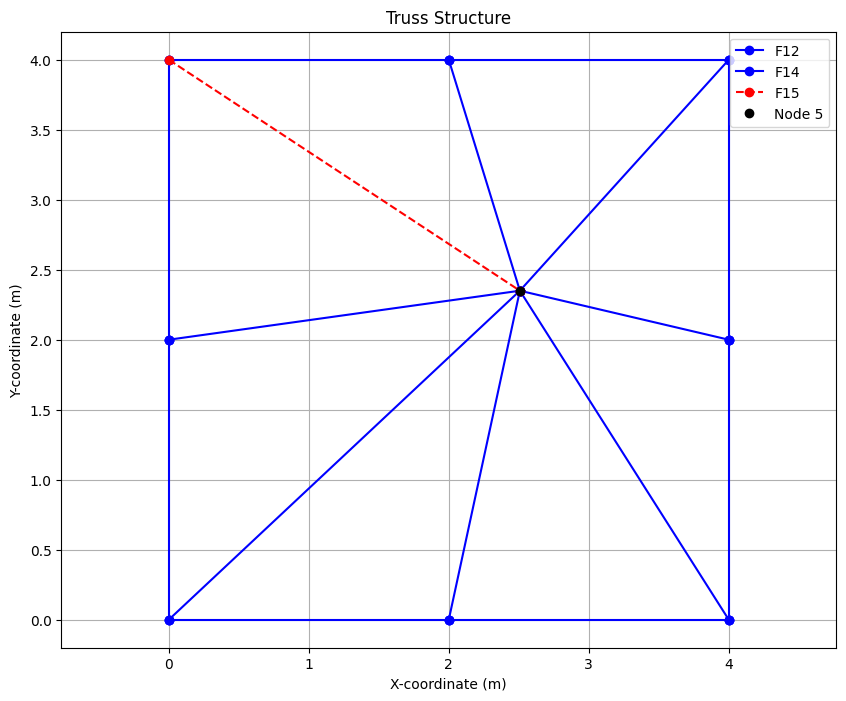

In [1]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Define the nodes with their initial coordinates
nodes = {
    1: (0.0, 4.0),
    2: (2.0, 4.0),
    3: (4.0, 4.0),
    4: (0.0, 2.0),
    5: (0.0, 0.0),  # Placeholder, will be updated
    6: (4.0, 2.0),
    7: (0.0, 0.0),
    8: (2.0, 0.0),
    9: (4.0, 0.0)
}

# Define the members including F15
members = [
    ('F12', 1, 2),
    ('F23', 2, 3),
    ('F45', 4, 5),
    ('F56', 5, 6),
    ('F78', 7, 8),
    ('F89', 8, 9),
    ('F14', 1, 4),
    ('F47', 4, 7),
    ('F25', 2, 5),
    ('F58', 5, 8),
    ('F36', 3, 6),
    ('F69', 6, 9),
    ('F35', 3, 5),
    ('F57', 5, 7),
    ('F59', 5, 9),
    ('F15', 1, 5)  # Added F15
]

# Fixed member force
F15_fixed = -4  # kN (compression)

def truss_equilibrium_residuals(variables):
    """
    Calculates residuals for the truss equilibrium equations.
    variables: [F12, F23, F45, F56, F78, F89,
               F14, F47, F25, F58, F36, F69,
               F35, F57, F59, x, y]
    Returns a list of 18 residuals corresponding to the equilibrium equations.
    """
    # Unpack variables
    F12, F23, F45, F56, F78, F89, F14, F47, F25, F58, F36, F69, F35, F57, F59, x, y = variables

    # Fixed member force
    F15 = F15_fixed  # kN (compression)

    # Fixed support reactions
    Rx7 = 0.0    # kN horizontal - right +ve
    Ry7 = 15.0   # kN upward
    Rx9 = 0.0    # kN horizontal - right +ve
    Ry9 = 15.0   # kN upward

    # Update node 5's coordinates
    local_nodes = nodes.copy()
    local_nodes[5] = (x, y)

    # Member forces dictionary including F15
    member_forces = {
        'F12': F12,
        'F23': F23,
        'F45': F45,
        'F56': F56,
        'F78': F78,
        'F89': F89,
        'F14': F14,
        'F47': F47,
        'F25': F25,
        'F58': F58,
        'F36': F36,
        'F69': F69,
        'F35': F35,
        'F57': F57,
        'F59': F59,
        'F15': F15  # Fixed member
    }

    # Initialize residuals list
    residuals = []

    # Function to calculate direction cosines
    def direction_cosines(start, end):
        xi, yi = local_nodes[start]
        xj, yj = local_nodes[end]
        dx = xj - xi
        dy = yj - yi
        L = np.sqrt(dx**2 + dy**2)
        if L == 0:
            raise ValueError(f"Zero length for member connecting Node {start} and Node {end}.")
        return dx / L, dy / L

    # Iterate through each node and apply equilibrium
    for node in range(1, 10):  # Nodes 1 through 9
        sum_fx = 0.0
        sum_fy = 0.0

        # Iterate through all members to find those connected to the current node
        for member in members:
            name, start, end = member
            force = member_forces[name]
            cx, cy = direction_cosines(start, end)

            if node == start:
                # Force acts away from the node (tension)
                sum_fx += force * cx
                sum_fy += force * cy
            elif node == end:
                # Force acts towards the node (compression)
                sum_fx -= force * cx
                sum_fy -= force * cy
            # If the member is not connected to the current node, do nothing

        # Apply external loads
        if node in [1, 2, 3]:
            sum_fy -= 10.0  # 10 kN downward load

        # Apply support reactions
        if node == 7:
            # Node 7 has reactions Rx7 and Ry7
            sum_fx += Rx7
            sum_fy += Ry7
        if node == 9:
            # Node 9 has reactions Rx9 and Ry9
            sum_fx += Rx9
            sum_fy += Ry9

        # Append equilibrium equations
        residuals.append(sum_fx)  # Sum of Fx = 0
        residuals.append(sum_fy)  # Sum of Fy = 0

    return residuals

# Initial guess for variables:
# [F12, F23, F45, F56, F78, F89,
#  F14, F47, F25, F58, F36, F69,
#  F35, F57, F59, x, y]

initial_guess = [
    10.0,  # F12
    10.0,  # F23
    10.0,  # F45
    10.0,  # F56
    15.0,  # F78
    15.0,  # F89
    10.0,  # F14
    15.0,  # F47
    10.0,  # F25
    10.0,  # F58
    10.0,  # F36
    15.0,  # F69
    10.0,  # F35
    10.0,  # F57
    10.0,  # F59
    2.0,   # x
    2.0    # y
]

# Solve the system using least_squares
result = least_squares(
    truss_equilibrium_residuals,
    initial_guess,
    ftol=1e-9,
    xtol=1e-9,
    verbose=2
)

# Check if the solution was successful
if result.success:
    solution = result.x
    F12, F23, F45, F56, F78, F89, F14, F47, F25, F58, F36, F69, F35, F57, F59, x, y = solution

    # Print the results
    print("\nSolution Found:")
    print(f"F12 (Member 1-2): {F12:.2f} kN")
    print(f"F23 (Member 2-3): {F23:.2f} kN")
    print(f"F45 (Member 4-5): {F45:.2f} kN")
    print(f"F56 (Member 5-6): {F56:.2f} kN")
    print(f"F78 (Member 7-8): {F78:.2f} kN")
    print(f"F89 (Member 8-9): {F89:.2f} kN")
    print(f"F14 (Member 1-4): {F14:.2f} kN")
    print(f"F47 (Member 4-7): {F47:.2f} kN")
    print(f"F25 (Member 2-5): {F25:.2f} kN")
    print(f"F58 (Member 5-8): {F58:.2f} kN")
    print(f"F36 (Member 3-6): {F36:.2f} kN")
    print(f"F69 (Member 6-9): {F69:.2f} kN")
    print(f"F35 (Member 3-5): {F35:.2f} kN")
    print(f"F57 (Member 5-7): {F57:.2f} kN")
    print(f"F59 (Member 5-9): {F59:.2f} kN")
    print(f"F15 (Member 1-5): {F15_fixed:.2f} kN (Fixed)")
    print(f"Position of Node 5: x = {x:.2f} m, y = {y:.2f} m")

    # Update the nodes dictionary with the solved position of Node 5
    nodes[5] = (x, y)

    # Plot the truss
    plt.figure(figsize=(10, 8))
    for member in members:
        name, start, end = member
        xi, yi = nodes[start]
        xj, yj = nodes[end]
        if name == 'F15':
            plt.plot([xi, xj], [yi, yj], 'r--o', label=name if start == 1 else "")
        else:
            plt.plot([xi, xj], [yi, yj], 'b-o', label=name if start == 1 else "")

    # Highlight Node 5
    plt.plot(x, y, 'ko', label='Node 5')

    plt.title('Truss Structure')
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # To maintain aspect ratio
    plt.show()
else:
    print("Solution did not converge.")
    print(result.message)

# Verification

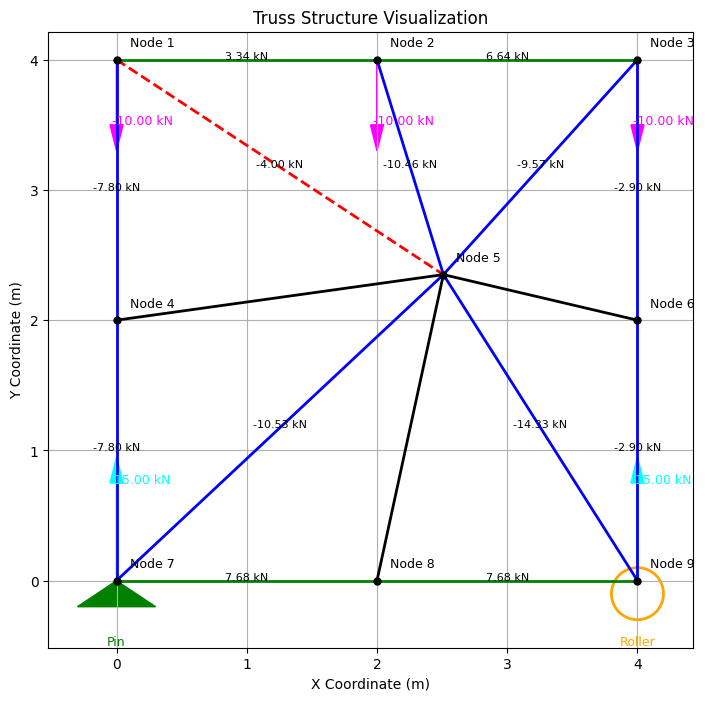

----- Equilibrium Check -----

Node 7:
  Sum of Fx = -0.0068 kN
  Sum of Fy = 0.0032 kN
  => In Equilibrium.

Node 8:
  Sum of Fx = 0.0000 kN
  Sum of Fy = 0.0000 kN
  => In Equilibrium.

Node 9:
  Sum of Fx = -0.0066 kN
  Sum of Fy = -0.0024 kN
  => In Equilibrium.

Node 4:
  Sum of Fx = 0.0000 kN
  Sum of Fy = 0.0000 kN
  => In Equilibrium.

Node 5:
  Sum of Fx = 0.0309 kN
  Sum of Fy = 0.0058 kN
  => Not in Equilibrium!

Node 6:
  Sum of Fx = 0.0000 kN
  Sum of Fy = 0.0000 kN
  => In Equilibrium.

Node 1:
  Sum of Fx = -0.0025 kN
  Sum of Fy = -0.0028 kN
  => In Equilibrium.

Node 2:
  Sum of Fx = 0.2111 kN
  Sum of Fy = -0.0065 kN
  => Not in Equilibrium!

Node 3:
  Sum of Fx = -0.2261 kN
  Sum of Fy = 0.0026 kN
  => Not in Equilibrium!

----- Angles Between Connected Members -----

Node 7: Angle between Member (7, 8) and Member (4, 7) = 90.00 degrees
Node 7: Angle between Member (7, 8) and Member (5, 7) = 43.11 degrees
Node 7: Angle between Member (4, 7) and Member (5, 7) = 46.89 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# Define Nodes
# ------------------------------

nodes = {
    7: (0, 0),
    8: (2, 0),
    9: (4, 0),
    4: (0, 2),
    5: (2.51, 2.35),  # Updated to solution coordinates
    6: (4, 2),
    1: (0, 4),
    2: (2, 4),
    3: (4, 4)
}

# ------------------------------
# Define Members
# ------------------------------
# Each member is a tuple of node numbers
members = [
    (1, 2), (2, 3), (4, 5), (5, 6), (7, 8),
    (8, 9), (1, 4), (4, 7), (2, 5), (5, 8),
    (3, 6), (6, 9), (3, 5), (5, 7), (5, 9),
    (1, 5)  # Added F15
]

# ------------------------------
# Define Member Forces (in kN)
# ------------------------------
# Positive force indicates tension; negative indicates compression
member_forces = {
    (1, 2): 3.34,
    (2, 3): 6.64,
    (4, 5): 0.00,
    (5, 6): -0.00,
    (7, 8): 7.68,
    (8, 9): 7.68,
    (1, 4): -7.80,
    (4, 7): -7.80,
    (2, 5): -10.46,
    (5, 8): -0.00,
    (3, 6): -2.90,
    (6, 9): -2.90,
    (3, 5): -9.57,
    (5, 7): -10.53,
    (5, 9): -14.33,
    (1, 5): -4.00  # Fixed member
}

# ------------------------------
# Define Supports
# ------------------------------
# Supports are handled separately as reactions
supports = {
    7: {'type': 'pin'},    # Node 7: Pin Support (Rx7, Ry7)
    9: {'type': 'roller'}  # Node 9: Roller Support (Ry9)
}

# ------------------------------
# Define External Loads
# ------------------------------
# 10 kN downward applied to the top three nodes: 1, 2, 3
external_loads = {
    1: (0, -10),
    2: (0, -10),
    3: (0, -10)
}

# ------------------------------
# Define Support Reactions
# ------------------------------
# Based on global equilibrium:
# Total downward force = 3 * 10 = 30 kN
# Total upward reactions = 30 kN, equally distributed:
# Ry7 = 15 kN, Ry9 = 15 kN
support_reactions = {
    7: (0, 15),  # Rx7, Ry7
    9: (0, 15)   # Rx9, Ry9
}

# ------------------------------
# Plotting the Truss
# ------------------------------
def plot_truss(nodes, members, member_forces, supports, external_loads, support_reactions):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot members
    for member in members:
        start, end = member
        x_values = [nodes[start][0], nodes[end][0]]
        y_values = [nodes[start][1], nodes[end][1]]
        force = member_forces.get(member, member_forces.get((end, start), 0))

        # Determine color based on force type
        if force > 0:
            color = 'green'  # Tension
        elif force < 0:
            color = 'blue'   # Compression
        else:
            color = 'black'  # Zero force

        # Special color for fixed member F15
        if member == (1,5):
            color = 'red'
            linestyle = '--'
        else:
            linestyle = '-'

        ax.plot(x_values, y_values, color=color, linestyle=linestyle, linewidth=2)

        # Calculate midpoint for force annotation
        mid_x = (nodes[start][0] + nodes[end][0]) / 2
        mid_y = (nodes[start][1] + nodes[end][1]) / 2

        # Annotate member forces
        if force != 0:
            ax.text(mid_x, mid_y, f'{force:.2f} kN', color='black', fontsize=8, ha='center')

    # Plot nodes
    for node, (x, y) in nodes.items():
        ax.plot(x, y, 'ko', markersize=5)
        ax.text(x + 0.1, y + 0.1, f'Node {node}', fontsize=9)

    # Plot supports
    for node, support in supports.items():
        x, y = nodes[node]
        if support['type'] == 'pin':
            # Draw a triangle for pin support
            triangle = plt.Polygon([[x-0.3, y-0.2], [x+0.3, y-0.2], [x, y]], closed=True, color='green')
            ax.add_patch(triangle)
            ax.text(x, y-0.5, 'Pin', color='green', fontsize=9, ha='center')
        elif support['type'] == 'roller':
            # Draw a circle for roller support
            circle = plt.Circle((x, y-0.1), 0.2, color='orange', fill=False, linewidth=2)
            ax.add_patch(circle)
            ax.text(x, y-0.5, 'Roller', color='orange', fontsize=9, ha='center')

    # Plot external loads
    for node, (fx, fy) in external_loads.items():
        x, y = nodes[node]
        if fy != 0:
            # Draw downward arrow for vertical loads
            ax.arrow(x, y, 0, fy*0.05, head_width=0.1, head_length=0.2, fc='magenta', ec='magenta')
            ax.text(x + 0.2, y + fy*0.05, f'{fy:.2f} kN', color='magenta', fontsize=9, ha='center')

    # Plot support reactions
    for node, (fx, fy) in support_reactions.items():
        x, y = nodes[node]
        if fx != 0:
            ax.arrow(x, y, fx*0.05, 0, head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
            ax.text(x + fx*0.05, y + 0.2, f'{fx:.2f} kN', color='cyan', fontsize=9, ha='center')
        if fy != 0:
            ax.arrow(x, y, 0, fy*0.05, head_width=0.1, head_length=0.2, fc='cyan', ec='cyan')
            ax.text(x + 0.2, y + fy*0.05, f'{fy:.2f} kN', color='cyan', fontsize=9, ha='center')

    ax.set_xlabel('X Coordinate (m)')
    ax.set_ylabel('Y Coordinate (m)')
    ax.set_title('Truss Structure Visualization')
    ax.grid(True)
    ax.set_aspect('equal', 'box')
    plt.show()

# ------------------------------
# Equilibrium Check
# ------------------------------
def equilibrium_check(nodes, members, member_forces, supports, external_loads, support_reactions):
    print("----- Equilibrium Check -----\n")
    equilibrium = True

    # Iterate through each node and check equilibrium
    for node in nodes:
        sum_fx = 0.0
        sum_fy = 0.0

        # Add support reactions if node is a support
        if node in support_reactions:
            rx, ry = support_reactions[node]
            sum_fx += rx
            sum_fy += ry

        # Add external loads if any
        if node in external_loads:
            fx, fy = external_loads[node]
            sum_fx += fx
            sum_fy += fy

        # Iterate through all members to find those connected to the current node
        connected_members = []
        for member in members:
            if node in member:
                connected_members.append(member)

        # Sum member forces
        for member in connected_members:
            start, end = member
            force = member_forces.get(member, member_forces.get((end, start), 0))

            # Determine the direction of the force relative to the node
            if node == start:
                # Force acts away from the node (tension)
                direction = 1
            else:
                # Force acts towards the node (compression)
                direction = -1

            # Calculate direction cosines
            dx = nodes[end][0] - nodes[start][0]
            dy = nodes[end][1] - nodes[start][1]
            length = np.hypot(dx, dy)
            if length == 0:
                raise ValueError(f"Zero length for member connecting Node {start} and Node {end}.")
            cos_theta = dx / length
            sin_theta = dy / length

            # Calculate force components
            fx_member = direction * force * cos_theta
            fy_member = direction * force * sin_theta

            sum_fx += fx_member
            sum_fy += fy_member

        # Print equilibrium equations for the node
        print(f"Node {node}:")
        print(f"  Sum of Fx = {sum_fx:.4f} kN")
        print(f"  Sum of Fy = {sum_fy:.4f} kN")

        # Check if sums are close to zero
        if not (np.isclose(sum_fx, 0, atol=1e-2) and np.isclose(sum_fy, 0, atol=1e-2)):
            equilibrium = False
            print("  => Not in Equilibrium!\n")
        else:
            print("  => In Equilibrium.\n")

    # Calculate and print angles between connected members
    print("----- Angles Between Connected Members -----\n")
    for node in nodes:
        connected_members = []
        for member in members:
            if node in member:
                connected_members.append(member)
        if len(connected_members) < 2:
            continue  # Need at least two members to define an angle
        # Calculate angles between each pair of connected members
        for i in range(len(connected_members)):
            for j in range(i+1, len(connected_members)):
                member1 = connected_members[i]
                member2 = connected_members[j]

                # Get vectors for both members relative to the node
                def get_vector(member, node):
                    start, end = member
                    if node == start:
                        return np.array([nodes[end][0] - nodes[start][0],
                                         nodes[end][1] - nodes[start][1]])
                    else:
                        return np.array([nodes[start][0] - nodes[end][0],
                                         nodes[start][1] - nodes[end][1]])

                vec1 = get_vector(member1, node)
                vec2 = get_vector(member2, node)

                # Calculate angle between vectors
                dot_product = np.dot(vec1, vec2)
                norm1 = np.linalg.norm(vec1)
                norm2 = np.linalg.norm(vec2)
                if norm1 == 0 or norm2 == 0:
                    angle_deg = 0.0
                else:
                    cos_angle = np.clip(dot_product / (norm1 * norm2), -1.0, 1.0)
                    angle_rad = np.arccos(cos_angle)
                    angle_deg = np.degrees(angle_rad)

                print(f"Node {node}: Angle between Member {member1} and Member {member2} = {angle_deg:.2f} degrees")

    if equilibrium:
        print("\nAll nodes are in equilibrium.")
    else:
        print("\nSome nodes are not in equilibrium.")

# ------------------------------
# Run the Functions
# ------------------------------
if __name__ == "__main__":
    plot_truss(nodes, members, member_forces, supports, external_loads, support_reactions)
    equilibrium_check(nodes, members, member_forces, supports, external_loads, support_reactions)
